In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
import rasterio as rio
from scipy.ndimage import gaussian_filter
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [ ]:
# #did this for x and y over area -605690.9911,-156721.1947,-827750.6645,-591983.6645 [EPSG:3031]
# gdal_rasterize -l MEaSUREs_FlowVectors -a vx -ts 22.0 11.0 -a_nodata 0.0 -te -605690.9911 -827750.6645 -156721.1947 -591983.6645 -ot Float32 -of GTiff "/Users/home/whitefar/DATA/Quantarctica3/Glaciology/MEaSUREs Ice Flow Velocity/MEaSUREs_FlowVectors.shp" /Users/home/whitefar/Downloads/x_measures.tif

In [3]:
with rio.open('/Volumes/arc_02/REMOTE_SENSING/ANTARCTIC_STRAIN/LISA750_2013_2017_elon_r750_v01.tif') as image:
    elon_extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    elon = image.read(1)
# x = np.linspace(x_extent[0],x_extent[1],u_x.shape[1]) #.astype('int')
# y = np.linspace(x_extent[3],x_extent[2],u_x.shape[0]) #.astype('int')

# xv, yv = np.meshgrid(x, y)

In [14]:
with rio.open('/Volumes/arc_02/REMOTE_SENSING/ANTARCTIC_STRAIN/LISA750_2013_2017_etrans_r750_v01.tif') as image:
    etrans_extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    etrans = image.read(1)

In [15]:
with rio.open('/Volumes/arc_02/REMOTE_SENSING/ANTARCTIC_STRAIN/LISA750_2013_2017_eshear_r750_v01.tif') as image:
    eshear_extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    eshear = image.read(1)

# we have x and y

(-734075.1, -721770.2)

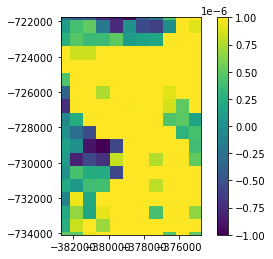

In [12]:
plt.imshow(elon,extent=elon_extent,vmin=-1e-6,vmax=1e-6)
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

(-734075.1, -721770.2)

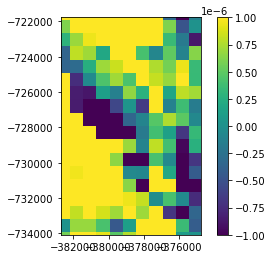

In [16]:
plt.imshow(etrans,extent=etrans_extent,vmin=-1e-6,vmax=1e-6)
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

In [18]:
mag = np.abs(etrans**2 + elon**2)

(-734075.1, -721770.2)

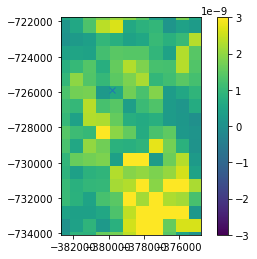

In [38]:
plt.imshow(mag*365.25,extent=elon_extent,vmin=-3e-9,vmax=3e-9)
plt.plot(-379828.7836872891, -725906.7900945658,'x')
plt.colorbar()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# get ice thickness at the same points

In [167]:
with rio.open('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MEaSUREs_Ice_Flow_Velocity/ice_thick_kamb.tif') as image:
    h_extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    h_arr = image.read(1)
xh = np.linspace(h_extent[0],h_extent[1],h_arr.shape[1]) #.astype('int')
yh = np.linspace(h_extent[3],h_extent[2],h_arr.shape[0]) #.astype('int')

xvh, yvh = np.meshgrid(xh, yh)
yh.shape

(236,)

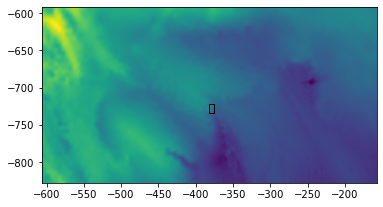

In [131]:
plt.imshow(h_arr,extent=np.array(h_extent)/1000)
rr =plt.Rectangle((xmin/1000, ymin/1000),
                        (xmax-xmin)/1000, (ymax-ymin)/1000,
                        fc='none',
                        color ='black',
                        linewidth = 1,
#                         linestyle="dotted"
                 )
plt.gca().add_patch(rr)
plt.show()

# resample at same points

In [225]:
h_out = sp.interpolate.griddata(np.hstack([xvh.reshape(xvh.size,1),yvh.reshape(xvh.size,1)]),h_arr.flatten(),(xv, yv),method='nearest')

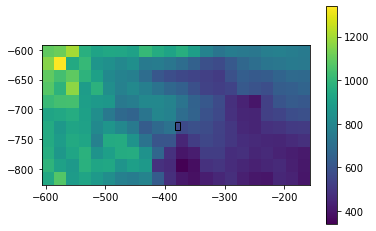

In [226]:
plt.imshow(h_out,extent=np.array(h_extent)/1000)
rr =plt.Rectangle((xmin/1000, ymin/1000),
                        (xmax-xmin)/1000, (ymax-ymin)/1000,
                        fc='none',
                        color ='black',
                        linewidth = 1,
#                         linestyle="dotted"
                 )
plt.gca().add_patch(rr)
plt.colorbar()
plt.show()

In [227]:
print(h_out.shape,u_x.shape,u_y.shape)

(11, 22) (11, 22) (11, 22)


In [241]:
#groundingline
xmin, xmax, ymin, ymax =-605690.9911,-156721.1947,-827750.6645,-591983.6645
bbox = box(xmin, xmax, ymin, ymax)
groundingline_path = glob.glob(f"/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/*.shp")[0]
groundingline =  gpd.read_file(groundingline_path)
# groundingline_path

groundingline = groundingline[groundingline.geometry.intersects(bbox)].copy()

coast = groundingline.geometry.iloc[0].exterior.coords[:]

gl = np.array([[x,y] for x,y in coast ])

gl = gl[(gl[:,0]< xmax) & (gl[:,0]> xmin) & (gl[:,1] > ymin) & (gl[:,1] <  ymax)].copy()

# divergence

how to compute divergence https://www.py4u.net/discuss/20293

https://www.youtube.com/watch?v=0OQB7y9NOz8

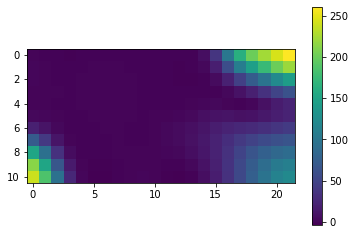

In [228]:
            
#smooth with gaussian filter
u_xss = gaussian_filter(u_x,sigma=1)
plt.imshow(u_xss)
plt.colorbar()

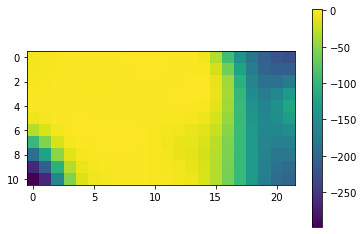

In [229]:
            
#smooth with gaussian filter
u_yss = gaussian_filter(u_y,sigma=1)
plt.imshow(u_yss)
plt.colorbar()

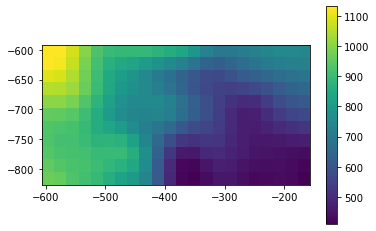

In [230]:
#smooth with gaussian filter
h_ss = gaussian_filter(h_out,sigma=1)
plt.imshow(h_ss,extent=np.array(h_extent)/1000)
plt.colorbar()

In [231]:
def divergence(f):
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], axis=i) for i in range(num_dims)])

In [232]:
F = [u_xss, u_yss]
h_divu = h_out*divergence(F) 

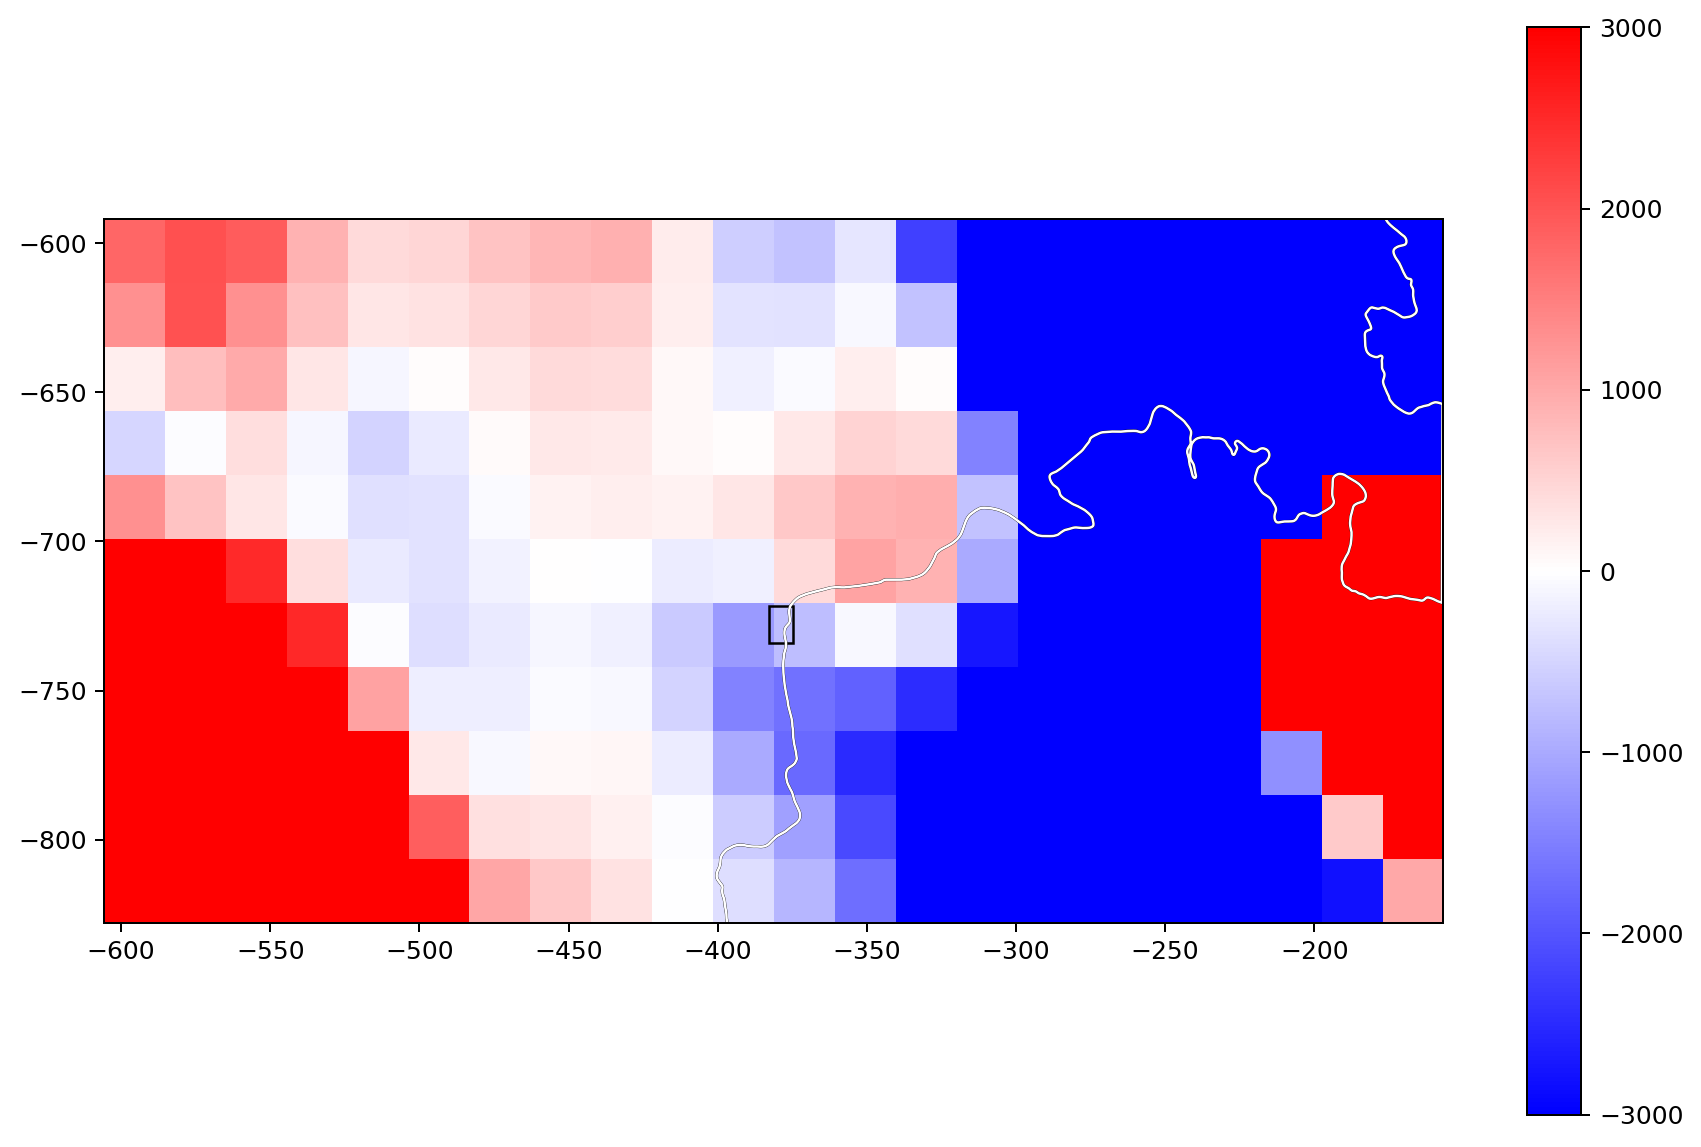

In [246]:
plt.figure( dpi=180,figsize=(12,8))
plt.imshow(h_divu,extent=np.array(x_extent)/1000,vmin=-3000,vmax=3000,cmap='bwr')
plt.colorbar()
rr =plt.Rectangle((xmin/1000, ymin/1000),
                        (xmax-xmin)/1000, (ymax-ymin)/1000,
                        fc='none',
                        color ='black',
                        linewidth = 1,
#                         linestyle="dotted"
                 )

plt.gca().add_patch(rr)
plt.plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=1.2)
plt.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=1)
plt.show()

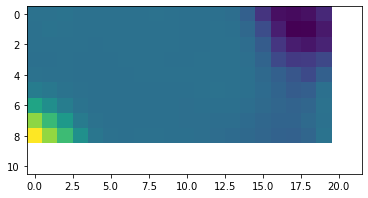

In [207]:
div_hu = h_out*divergence(F) + u_xss*np.gradient(h_out, axis=0)+ u_yss*np.gradient(h_out, axis=1)
plt.imshow(div_hu)

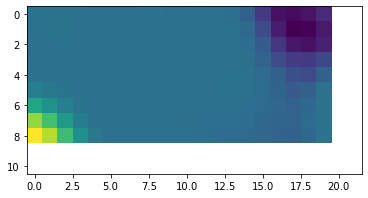

In [211]:
F1 = [h_out*u_xss, h_out*u_yss]
div_hu1 = divergence(F1)
plt.imshow(div_hu1)

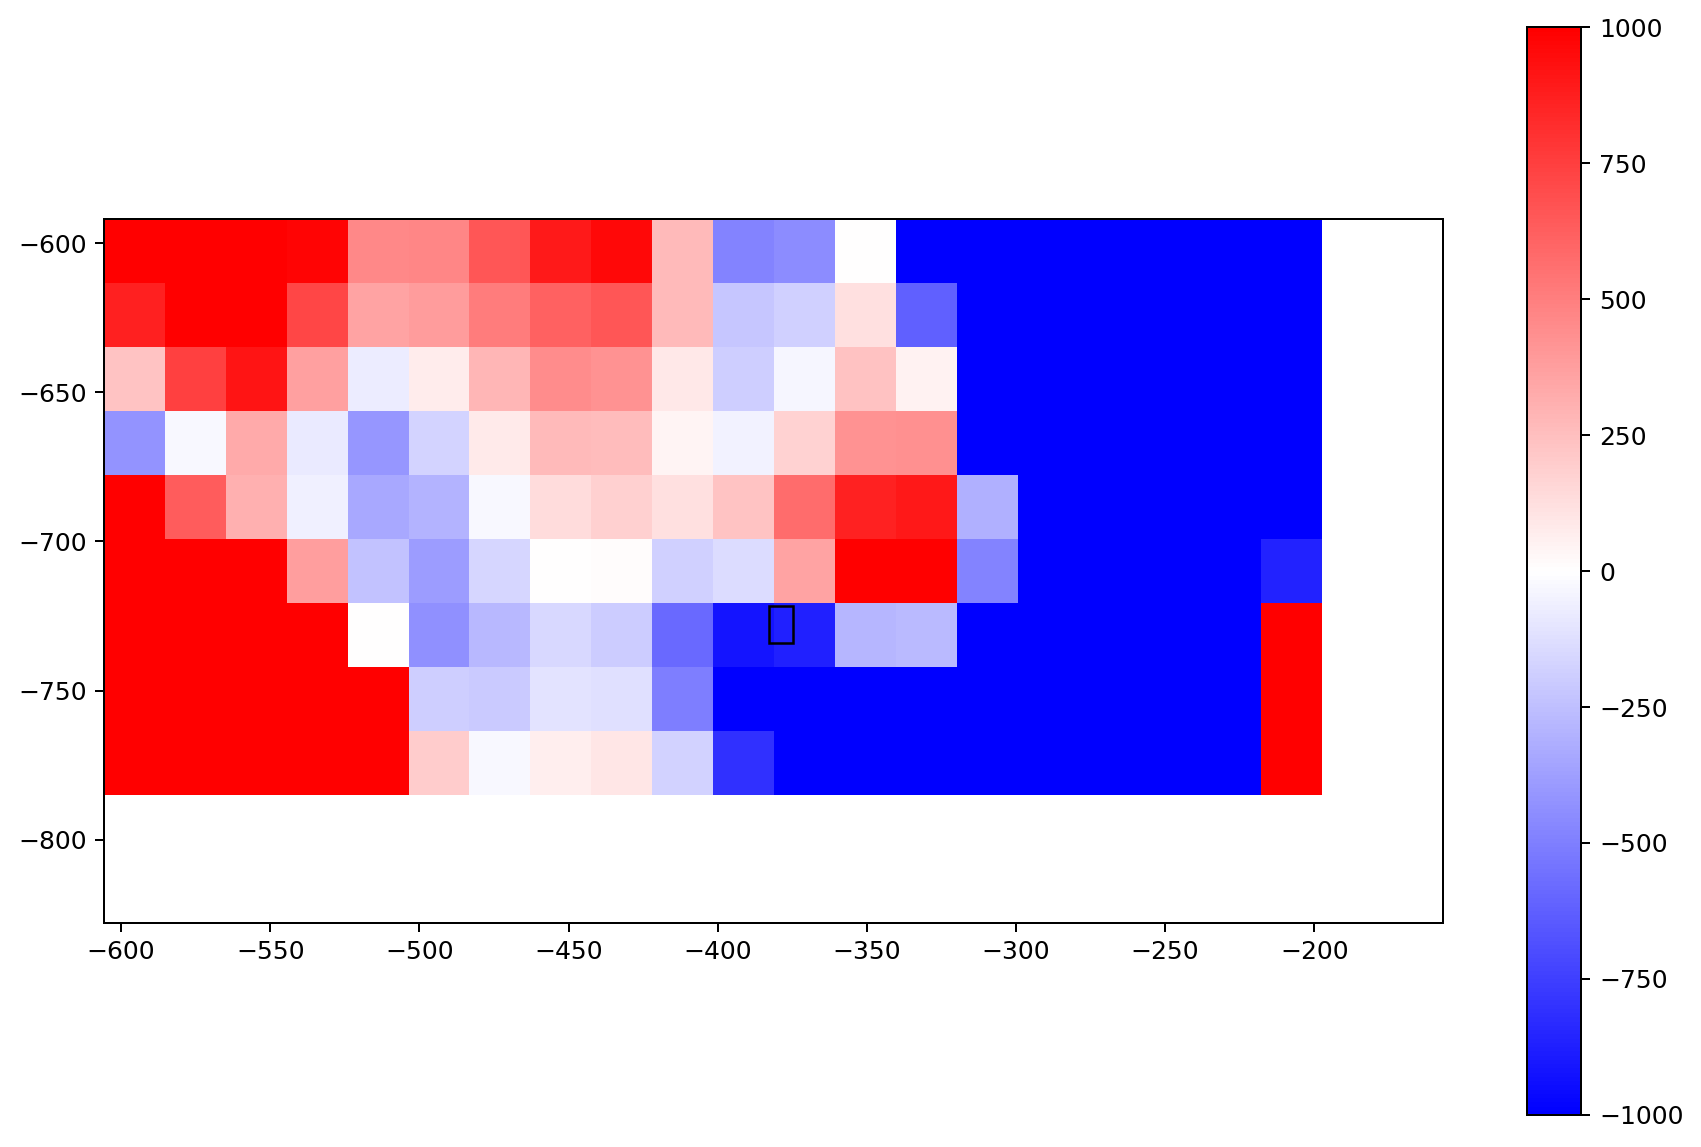

In [212]:
plt.figure( dpi=180,figsize=(12,8))
plt.imshow(div_hu1,extent=np.array(x_extent)/1000,vmin=-1000,vmax=1000,cmap='bwr')
plt.colorbar()
rr =plt.Rectangle((xmin/1000, ymin/1000),
                        (xmax-xmin)/1000, (ymax-ymin)/1000,
                        fc='none',
                        color ='black',
                        linewidth = 1,
#                         linestyle="dotted"
                 )
plt.gca().add_patch(rr)
plt.show()

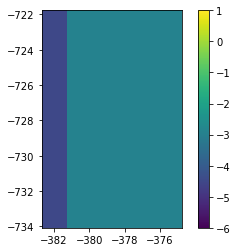

In [114]:
plt.imshow(g,extent=np.array(x_extent)/1000,vmin=-6,vmax=1)
plt.colorbar()
plt.xlim([xmin/1000,xmax/1000])
plt.ylim([ymin/1000,ymax/1000])
plt.show()

In [67]:
xmin, xmax,ymin,ymax  = -402700.0, -364825.0,-740000, -710000

In [74]:
pt = [-378000,-728000]
xmin, xmax,ymin,ymax  = pt[0]-3000,pt[0]+3000,pt[1]-3000,pt[1]+3000
xmin, xmax,ymin,ymax  = -450000.0,-30000,-800000,-650000

In [75]:
gdf = gpd.read_file('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MEaSUREs_Ice_Flow_Velocity/MEaSUREs_FlowVectors.shp')
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
gdf.query(f"x > {xmin} & x < {xmax} & y > {ymin} & y < {ymax}",inplace=True)

In [76]:
gdf.shape

(147, 7)

<AxesSubplot:>

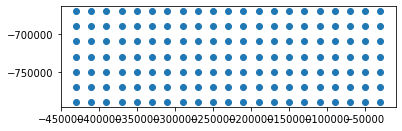

In [77]:
gdf.plot()

In [14]:
!ls /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MEaSUREs_Ice_Flow_Velocity/MEaSUREs_FlowVectors.shp

MEaSUREs_FlowSpeed_450m.txt
MEaSUREs_FlowSpeedError_450m.tif
MEaSUREs_FlowSpeedError_450m.tif.aux.xml
MEaSUREs_FlowSpeedError_450m.tif.ovr
MEaSUREs_FlowSpeedError_450m.txt
MEaSUREs_FlowVectors.cpg
MEaSUREs_FlowVectors.dbf
MEaSUREs_FlowVectors.prj
MEaSUREs_FlowVectors.qix
MEaSUREs_FlowVectors.shp
MEaSUREs_FlowVectors.shx
MEaSUREs_FlowVectors.txt
MEaSUREs_IceFlowSpeed_450m.tif
MEaSUREs_IceFlowSpeed_450m.tif.aux.xml
MEaSUREs_IceFlowSpeed_450m.tif.ovr
MEaSUREs Ice Flow Velocity.txt
